In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers import AutoencoderKL
from diffusers import BitsAndBytesConfig
from diffusers import StableDiffusionInpaintPipeline
from diffusers import UNet2DConditionModel
from PIL import Image
from PIL import ImageOps

torch.backends.cuda.matmul.allow_tf32 = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

dtype = torch.float16

model_version = "stabilityai/stable-diffusion-2-inpainting"
DCS = False
username = "sneakers-pretrained-models"
if DCS:
  models_path = f"/dcs/large/{username}"
else:
  models_path = None

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype,
)
unet_nf4 = UNet2DConditionModel.from_pretrained(
    model_version,
    subfolder="unet",
    quantization_config=nf4_config,
    torch_dtype=dtype,
    use_safetensors=True,
    cache_dir=models_path,
)

vae_nf4 = AutoencoderKL.from_pretrained(
    model_version,
    subfolder="vae",
    quantization_config=nf4_config,
    torch_dtype=dtype,
    use_safetensors=True,
    cache_dir=models_path,
)

pipe_inpaint: StableDiffusionInpaintPipeline = StableDiffusionInpaintPipeline.from_pretrained(
    model_version,
    variant="fp16",
    unet=unet_nf4,
    vae=vae_nf4,
    torch_dtype=dtype,
    use_safetensors=True,
    cache_dir=models_path,
)

pipe_inpaint.text_encoder = pipe_inpaint.text_encoder.to(device, dtype)
pipe_inpaint.unet.to(memory_format=torch.channels_last)
pipe_inpaint = pipe_inpaint.to(device=device, memory_format=torch.channels_last)
pipe_inpaint.safety_checker = None
pipe_inpaint.vae.requires_grad_(False)
pipe_inpaint.unet.requires_grad_(False)

# pipe = torch.compile(pipe)

Using device: cuda


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

UNet2DConditionModel(
  (conv_in): Conv2d(9, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear4bit(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear4bit(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Linear4bit(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear4bit(in_features=320, out_features=320, bias=False)
                (to_k): Linear4bit(in_features=320, out_features=320, bias=False)
                (to_v): Linear4bi

In [ ]:
def prepare_mask_and_masked(
    image: Image.Image,
    mask: Image.Image,
) -> tuple[torch.Tensor, torch.Tensor]:
  """
    Preprocesses an image and mask for deep learning models.

    Args:
        image: Input image (PIL Image)
        mask: Input mask (PIL Image)
        inverted: If True, inverts the mask values

    Returns:
        (mask_tensor, masked_image_tensor)
    """
  # Convert image to tensor and normalize
  image = np.array(image.convert("RGB"))
  image = image[None].transpose(0, 3, 1, 2)
  image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

  # Convert mask to binary tensor
  mask = np.array(mask.convert("L")).astype(np.float32) / 255.0
  mask = mask[None, None]
  mask = (mask >= 0.5).astype(np.float32)

  mask = torch.from_numpy(1 - mask)
  masked_image = image * (mask < 0.5)

  return mask, masked_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


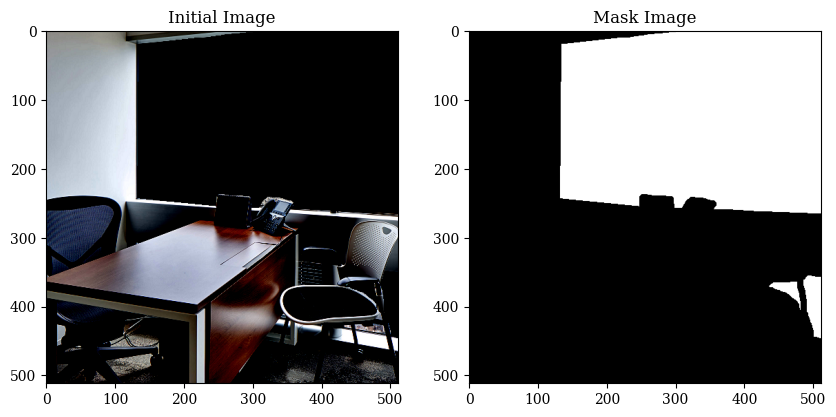

In [ ]:
# Load initial image
image_dir = "./images/"
image_name = "002.png"
mask_name = "002_masked.png"
init_image = plt.imread(image_dir + image_name)
mask_image = plt.imread(image_dir + mask_name)

size_2d = (512, 512)

init_image = Image.open(image_dir + image_name).convert('RGB').resize(size_2d)
mask_image = Image.open(image_dir + mask_name).convert('RGB').resize(size_2d)
# mask_image = ImageOps.invert(mask_image).resize(size_2d)

mask_image, init_image = prepare_mask_and_masked(init_image, mask_image)

# Plot the initial image and mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(init_image[0].permute(1, 2, 0))
axes[0].set_title("Initial Image")
# axes[0].axis("off")
axes[1].imshow(mask_image[0].permute(1, 2, 0), cmap="gray")
axes[1].set_title("Mask Image")
# axes[1].axis("off")
plt.show()

/home/jakub/miniconda3/envs/ml/lib/python3.12/site-packages/diffusers/image_processor.py:704: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(


Registering hook for down_blocks.0.attentions.0.transformer_blocks.0.attn1
Registering hook for down_blocks.0.attentions.0.transformer_blocks.0.attn2
Registering hook for down_blocks.0.attentions.1.transformer_blocks.0.attn1
Registering hook for down_blocks.0.attentions.1.transformer_blocks.0.attn2
Registering hook for down_blocks.1.attentions.0.transformer_blocks.0.attn1
Registering hook for down_blocks.1.attentions.0.transformer_blocks.0.attn2
Registering hook for down_blocks.1.attentions.1.transformer_blocks.0.attn1
Registering hook for down_blocks.1.attentions.1.transformer_blocks.0.attn2
Registering hook for down_blocks.2.attentions.0.transformer_blocks.0.attn1
Registering hook for down_blocks.2.attentions.0.transformer_blocks.0.attn2
Registering hook for down_blocks.2.attentions.1.transformer_blocks.0.attn1
Registering hook for down_blocks.2.attentions.1.transformer_blocks.0.attn2
Registering hook for up_blocks.1.attentions.0.transformer_blocks.0.attn1
Registering hook for up_blo

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Result:
StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7617DE5FF6B0>], nsfw_content_detected=None)


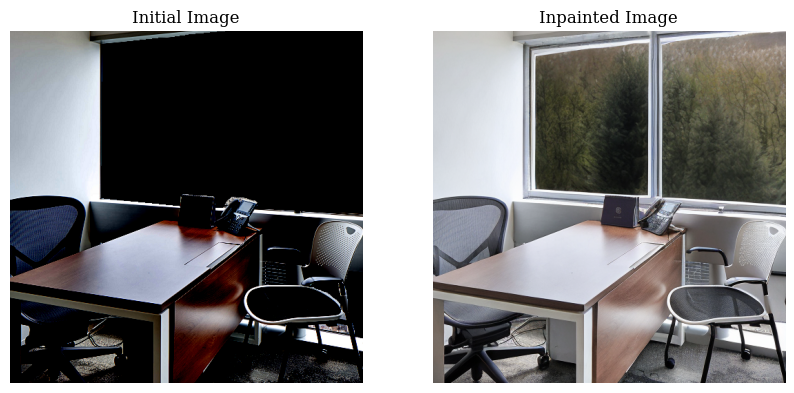

In [ ]:
def register_attention_hooks(unet):
  attention_maps = {}

  def hook_fn(module, input, output):
    if isinstance(output, tuple):  # Handle different diffusers versions
      output = output[0]
    attention_maps[module.name] = output.detach().cpu().numpy()

  for name, module in unet.named_modules():
    # Only capture the normalized attention maps
    if "attn1" in name or "attn2" in name:  # Capture both self- and cross-attention
      # Do no register hook for the submodules of the attention module
      if "attn1." in name or "attn2." in name:
        continue
      print(f"Registering hook for {name}")
      module.name = name
      module.register_forward_hook(hook_fn)

  return attention_maps


attention_maps = register_attention_hooks(pipe_inpaint.unet)

result = pipe_inpaint(
    prompt="window",
    image=init_image,
    mask_image=mask_image,
    # guidance_scale=7.5,
)

print("Result:")
print(result)

# Plot the inpainted image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(init_image[0].permute(1, 2, 0))
axes[0].set_title("Initial Image")
axes[0].axis("off")
axes[1].imshow(result.images[0])
axes[1].set_title("Inpainted Image")
axes[1].axis("off")
plt.show()

Number of layers: 32


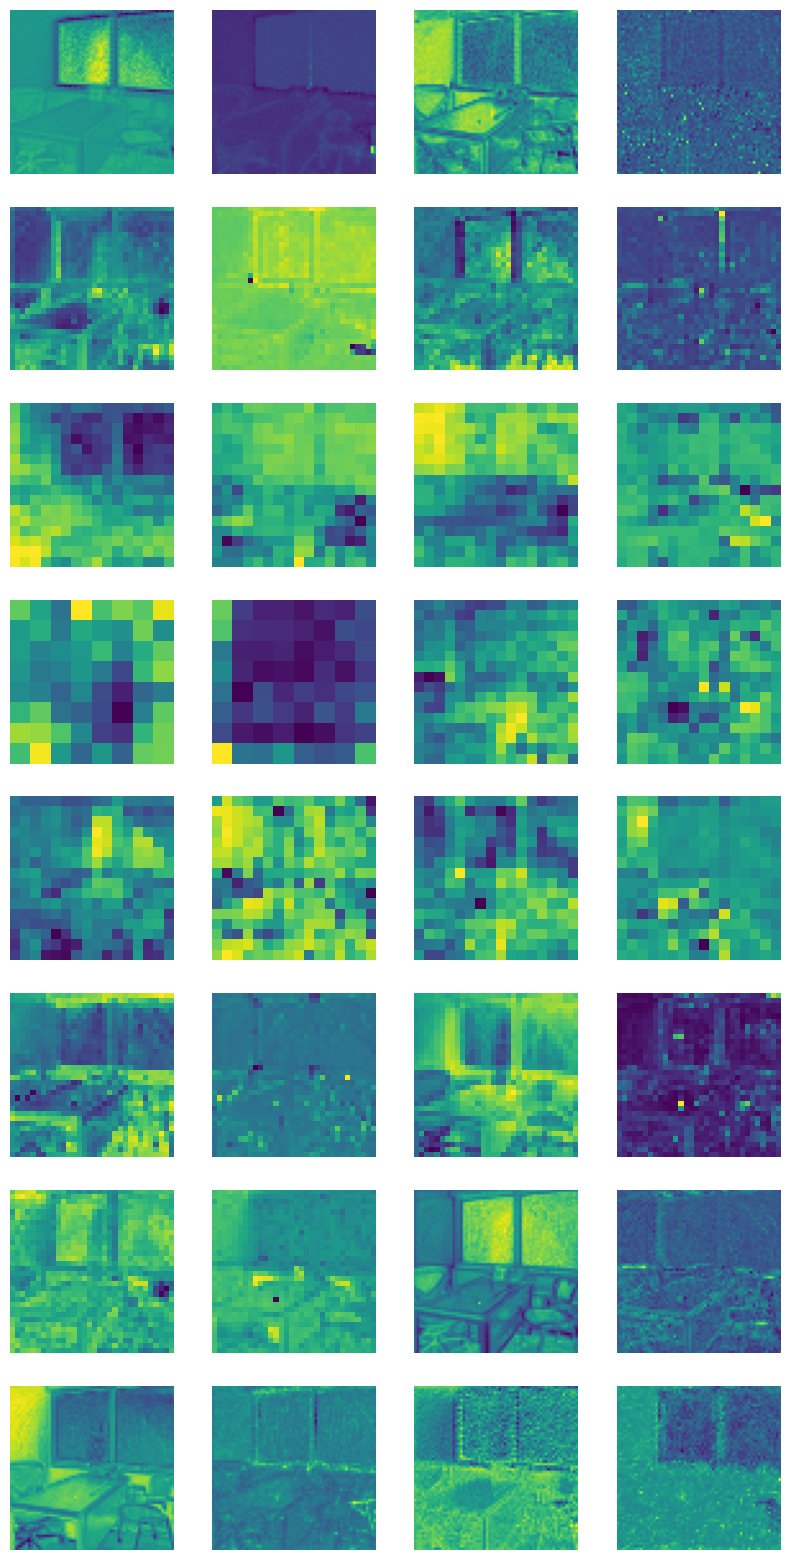

shape: (64, 64)
shape: (2, 4096, 320), min: -0.026611328125, max: 0.028289794921875
shape: (64, 64)
shape: (2, 4096, 320), min: -0.004085540771484375, max: 0.021026611328125
shape: (64, 64)
shape: (2, 4096, 320), min: -0.04248046875, max: 0.03277587890625
shape: (64, 64)
shape: (2, 4096, 320), min: -0.00902557373046875, max: 0.01495361328125
shape: (32, 32)
shape: (2, 1024, 640), min: -0.046966552734375, max: 0.032470703125
shape: (32, 32)
shape: (2, 1024, 640), min: -0.01529693603515625, max: -0.0003135204315185547
shape: (32, 32)
shape: (2, 1024, 640), min: -0.03863525390625, max: 0.050018310546875
shape: (32, 32)
shape: (2, 1024, 640), min: -0.002208709716796875, max: 0.006168365478515625
shape: (16, 16)
shape: (2, 256, 1280), min: -0.046051025390625, max: 0.03887939453125
shape: (16, 16)
shape: (2, 256, 1280), min: -0.00763702392578125, max: 0.0026702880859375
shape: (16, 16)
shape: (2, 256, 1280), min: -0.058685302734375, max: 0.0302581787109375
shape: (16, 16)
shape: (2, 256, 128

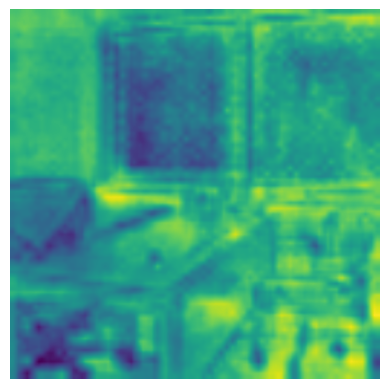

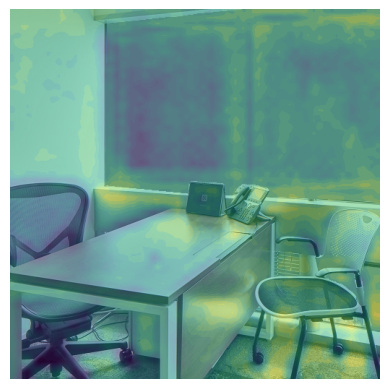

In [5]:
num_layers = len(attention_maps)
print(f"Number of layers: {num_layers}")

# Plot the attention maps
fig, axex = plt.subplots(8, 4, figsize=(10, 20))

for i, (name, layer) in enumerate(attention_maps.items()):
  j = i // 4
  # Print the shape of the attention maps
  attn = layer
  # attn is of shape (A, B, C), we want to average over A and C such that we
  # only have B left
  avg_attention = np.mean(attn, axis=(0, 2))

  # Shape to a square
  sqrt_len = int(np.sqrt(avg_attention.size))
  ax = axex[j, i % 4]
  axex[j, i % 4].imshow(
      avg_attention.reshape(sqrt_len, sqrt_len),
      cmap='viridis',
  )
  axex[j, i % 4].axis("off")
plt.show()

# Scale up all the attention maps to the image size
upscaled_attention_maps = []
for name, layer in attention_maps.items():
  # Upscale the attention maps to the image size
  avg_attention = np.mean(layer, axis=(0, 2))
  sqrt_len = int(np.sqrt(avg_attention.size))
  avg_attention = avg_attention.reshape(sqrt_len, sqrt_len)
  print(f"shape: {avg_attention.shape}")
  upscaled = torch.nn.functional.interpolate(
      torch.from_numpy(avg_attention)[None, None, :, :],
      size=(512, 512),
      mode="bilinear",
      align_corners=False,
  )

  min_val = upscaled.min()
  max_val = upscaled.max()

  print(f"shape: {layer.shape}, min: {min_val}, max: {max_val}")
  normalized = (upscaled - min_val) / (max_val - min_val)
  upscaled_attention_maps.append(upscaled)

# Take the average of all the attention maps
avg_attention_map = torch.stack(upscaled_attention_maps).mean(dim=0)[0,
                                                                     0].numpy()

# Plot the average attention map
plt.imshow(avg_attention_map, cmap='viridis')
plt.axis("off")
plt.show()

# Overlay the attention map on the image
plt.imshow(init_image[0].permute(1, 2, 0) / 2.0 + 0.5)
avg_attention_map += 1.0
avg_attention_map /= 2.0
plt.imshow(avg_attention_map, alpha=0.5, cmap='viridis')
plt.axis("off")
plt.show()